In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

import random
from typing import Callable
from sklearn.preprocessing import minmax_scale

2024-04-04 10:22:53.539820: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 10:22:54.131039: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 10:22:56.104195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 10:23:01.674672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


>Justification des choix des données :

Dans le dessein de mieux appréhender le fonctionnement des autoencodeurs et d'illustrer leur capacité générative, nous avons pris la décision de construire un ensemble de données exclusivement composé d'images représentant les chiffres 1 et 7 (MNIST Digits). Les chiffres 1 et 7 présentent des similitudes marquées dans leur écriture. En introduisant divers types de bruits (dont nous discuterons ultérieurement), il devient possible de constituer un ensemble de données très varié et d'entraîner un modèle robuste. Par souci de performance et de faisabilité logistique, nous avons restreint notre choix à deux chiffres (1 et 7). Cependant, une exploration ultérieure sera proposée, où nous inclurons quatre chiffres (8, 5, 3 et 9) présentant des similitudes significatives.

>Justification des choix des bruits :

Deux types de bruits sont déjà implémentés, à savoir le "speckle" et le "gaussian".
- Le bruit speckle, également appelé bruit de chatoiement, fait référence à toute fluctuation parasite ou toute dégradation subie par une image depuis le moment de son acquisition jusqu'à son enregistrement. Ce bruit illustre un cas concret où l'image est capturée par un appareil numérique puis transmise au modèle, la présence de bruit étant inévitable. Ce type de bruit se distingue par sa capacité à séparer le premier plan de l'arrière-plan, ce qui met en valeur le chiffre tout en le dégradant.
- Le bruit gaussien, en traitement du signal, est un bruit caractérisé par une densité de probabilité qui suit une distribution gaussienne (loi normale). Les principales sources de bruit gaussien dans les images numériques surviennent pendant l'acquisition, par exemple le bruit du capteur causé par un mauvais éclairage et/ou une température élevée. Ce bruit uniforme permet au modèle d'être plus résilient dans sa classification car il n'accentue pas le chiffre mais uniformise la dégradation de l'image.
- Le bruit "salt and pepper", ou bruit sel ou poivre, correspond à une altération aléatoire subie par une image numérique, entraînant la modification de l'intensité de certains pixels (répartis de manière aléatoire dans l'image) jusqu'à atteindre la valeur minimale ou maximale de la plage dynamique du pixel, respectivement 0 et 255 dans le cas d'une image numérique codée en 8 bits. Ce type de bruit permet au modèle de traiter des valeurs extrêmes (0 ou 255).

Chacun des bruits sera scalé avec un paramètre `scale` qui permet de modifier l'intensité de la présence du bruit dans l'image. En jouant sur les valeurs de ce paramètre nous pourront créer des données plus ou moins bruitées et donc tester les limites de robustesse de nos modèles ainsi que de leur capacité à apprendre même avec beaucoup de bruit.



In [35]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
    'salt_and_pepper' Randomly chosen pixels that are converted in black or white based on a probability.
    'scale' : the scale at which the noise is present in the image. It allows to create images with little to no noise and images with a lot of noise (for model robustness).
                
We define a function that adds each noise when called from main function
Input & Output: np array


                
"""

def add_noise(img, noise_type="gaussian", scale=0.5):
  row, col = 28, 28
  img = img.astype(np.float32)

  match noise_type:
    case "gaussian":
      mean  = 0
      var   = 0.01
      sigma = var**.5
      noise = np.random.normal(mean, sigma, img.shape)
      noise = noise.reshape(row, col)
      img   = img + (noise*scale)
      return img
     
    case "speckle" :
      noise = np.random.randn(row, col)
      noise = noise.reshape(row, col)
      img   = img + (img*noise*scale)
      return img
     
    case "salt_pepper" :
      prob=0.4*scale # 1/4 is the base probability of a pixel being transformed. It is scaled down or up with the scale parameter
      output = img.copy()
      if len(img.shape) == 2:
          black = 0
          white = 1            
      probs = np.random.random(output.shape[:2])
      output[probs < (prob / 2)] = black
      output[probs > 1 - (prob/2)] = white
      return output     
    case _:
      return img


In [4]:
mnist_ = mnist.load_data()

train_mask = (mnist_[0][1] == 1) | (mnist_[0][1] == 7)
test_mask = (mnist_[1][1] == 1) | (mnist_[1][1] == 7)

(xtrain, ytrain) = mnist_[0][0][train_mask], mnist_[0][1][train_mask]
(xtest, ytest) = mnist_[1][0][test_mask], mnist_[1][1][test_mask]

In [5]:
xtrain = np.array([minmax_scale(x) for x in xtrain])
xtest = np.array([minmax_scale(x) for x in xtest])

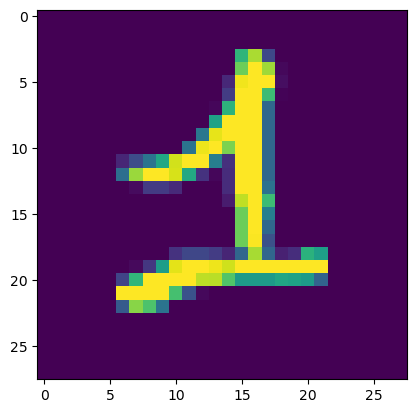

In [15]:
plt.imshow(xtrain[6].reshape((28, 28)))

In [16]:
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

No of training datapoints:13007
No of Test datapoints:2163


In [36]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle", "salt_pepper"]
noise_ct = 0
noise_id = 0
traindata = np.zeros((len(xtrain), 28, 28))


for idx in tqdm(range(len(xtrain))):
  if noise_ct < len(xtrain)/3:
    noise_ct += 1
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], scale=1)
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest))):
  if noise_ct < len(xtest)/3:
    noise_ct += 1
    x = add_noise(xtest[idx], noise_type=noises[noise_id])
    testdata[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

  0%|          | 0/13007 [00:00<?, ?it/s]

 62%|██████▏   | 8086/13007 [00:00<00:00, 27233.85it/s]


gaussian noise addition completed to images

speckle noise addition completed to images


100%|██████████| 13007/13007 [00:00<00:00, 30331.47it/s]



salt_pepper noise addition completed to images


100%|██████████| 2163/2163 [00:00<00:00, 31650.10it/s]


gaussian noise addition completed to images

speckle noise addition completed to images

salt_pepper noise addition completed to images


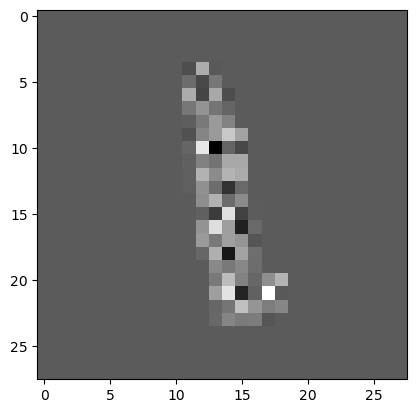

In [33]:
plt.imshow(traindata[5000], cmap="gray")

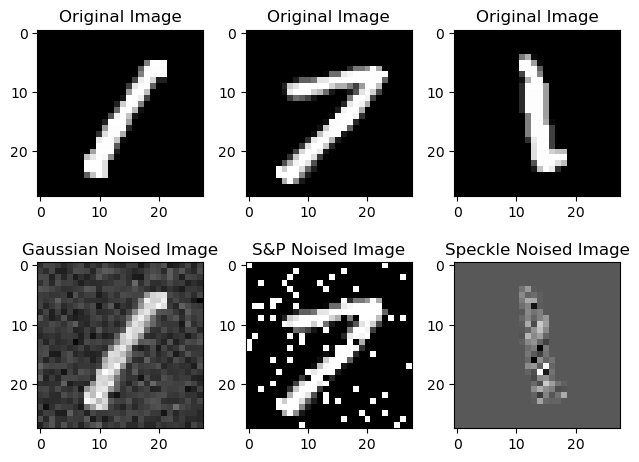

In [37]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,3)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0], cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0], cmap='gray')
axes[1,0].set_title("Gaussian Noised Image")

#showing images with salt and pepper noise
axes[0,1].imshow(xtrain[13000], cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[13000], cmap="gray")
axes[1,1].set_title("S&P Noised Image")

#showing imags with the speckle noise
axes[0,2].imshow(xtrain[5000], cmap='gray')
axes[0,2].set_title("Original Image")
axes[1,2].imshow(traindata[5000], cmap="gray")
axes[1,2].set_title("Speckle Noised Image")

plt.tight_layout()

In [8]:
class noisedDataset(Dataset):
  def __init__(self, 
               datasetnoised: np.ndarray, 
               datasetclean: np.ndarray, 
               labels: np.ndarray,
               transform: Callable):
    self.noise = datasetnoised
    self.clean = datasetclean
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self, idx):
    xNoise = self.noise[idx]
    xClean = self.clean[idx]
    y = self.labels[idx]
    
    if self.transform != None:
      xNoise = self.transform(xNoise)
      xClean = self.transform(xClean)

    return (xNoise, xClean, y)
    

In [9]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [10]:
trainset.clean[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0, 124, 253, 255,  63,   0,   0,   0,   0,
          0,   0],
       [  

In [11]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""

batch_size = 32

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

In [16]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  def __init__(self, hidden_layer_nb=1, hidden_size = 256, latent_size=64, img_size=28*28):
    super(denoising_model,self).__init__()

    encode_sequence_input = [nn.Linear(img_size, hidden_size), nn.ReLU()]
    encode_sequence_output = [nn.Linear(hidden_size, latent_size), nn.ReLU()]
    encode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      encode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      encode_sequence_hidden.append(nn.ReLU())

    encode_sequence = encode_sequence_input + encode_sequence_hidden + encode_sequence_output
        
    self.encoder = nn.Sequential(
      *encode_sequence
    )

    decode_sequence_input = [nn.Linear(latent_size, hidden_size), nn.ReLU()]
    decode_sequence_output = [nn.Linear(hidden_size, img_size), nn.Sigmoid()]
    decode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      decode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      decode_sequence_hidden.append(nn.ReLU())

    decode_sequence = decode_sequence_input + decode_sequence_hidden + decode_sequence_output

    self.decoder = nn.Sequential(
      *decode_sequence
    )
 
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    
    return x

In [17]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

In [22]:
model = denoising_model(hidden_layer_nb=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

In [23]:
print(model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [15]:
epochs = 120
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0
for epoch in range(epochs):
  print("Entering Epoch: ", epoch)
  for dirty, clean, label in tqdm((trainloader)):
    
    
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
    dirty, clean = dirty.to(device), clean.to(device)

    optimizer.zero_grad()

    #-----------------Forward Pass----------------------
    output = model(dirty)
    loss = criterion(output, clean)

    #-----------------Backward Pass---------------------
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    epochloss += loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss = 0
  print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))
 

Entering Epoch:  0


100%|██████████| 407/407 [00:01<00:00, 268.06it/s]


======> epoch: 0/120, Loss:0.21187371015548706
Entering Epoch:  1


100%|██████████| 407/407 [00:01<00:00, 291.21it/s]


======> epoch: 1/120, Loss:0.06975259631872177
Entering Epoch:  2


100%|██████████| 407/407 [00:01<00:00, 306.24it/s]


======> epoch: 2/120, Loss:0.05302748456597328
Entering Epoch:  3


100%|██████████| 407/407 [00:01<00:00, 306.55it/s]


======> epoch: 3/120, Loss:0.05405935272574425
Entering Epoch:  4


100%|██████████| 407/407 [00:01<00:00, 307.07it/s]


======> epoch: 4/120, Loss:0.05789869278669357
Entering Epoch:  5


100%|██████████| 407/407 [00:01<00:00, 279.01it/s]


======> epoch: 5/120, Loss:0.051925987005233765
Entering Epoch:  6


100%|██████████| 407/407 [00:01<00:00, 321.10it/s]


======> epoch: 6/120, Loss:0.0421886071562767
Entering Epoch:  7


100%|██████████| 407/407 [00:01<00:00, 319.06it/s]


======> epoch: 7/120, Loss:0.049585018306970596
Entering Epoch:  8


100%|██████████| 407/407 [00:01<00:00, 293.87it/s]


======> epoch: 8/120, Loss:0.0452340766787529
Entering Epoch:  9


100%|██████████| 407/407 [00:01<00:00, 315.25it/s]


======> epoch: 9/120, Loss:0.04425365477800369
Entering Epoch:  10


100%|██████████| 407/407 [00:01<00:00, 297.58it/s]


======> epoch: 10/120, Loss:0.04131798446178436
Entering Epoch:  11


100%|██████████| 407/407 [00:01<00:00, 304.16it/s]


======> epoch: 11/120, Loss:0.03753295913338661
Entering Epoch:  12


100%|██████████| 407/407 [00:01<00:00, 284.84it/s]


======> epoch: 12/120, Loss:0.03256509453058243
Entering Epoch:  13


100%|██████████| 407/407 [00:01<00:00, 310.34it/s]


======> epoch: 13/120, Loss:0.04440375044941902
Entering Epoch:  14


100%|██████████| 407/407 [00:01<00:00, 316.19it/s]


======> epoch: 14/120, Loss:0.04674661159515381
Entering Epoch:  15


100%|██████████| 407/407 [00:01<00:00, 308.38it/s]


======> epoch: 15/120, Loss:0.038217414170503616
Entering Epoch:  16


100%|██████████| 407/407 [00:01<00:00, 312.88it/s]


======> epoch: 16/120, Loss:0.03880421072244644
Entering Epoch:  17


100%|██████████| 407/407 [00:01<00:00, 340.31it/s]


======> epoch: 17/120, Loss:0.03213829547166824
Entering Epoch:  18


100%|██████████| 407/407 [00:01<00:00, 289.37it/s]


======> epoch: 18/120, Loss:0.03950062394142151
Entering Epoch:  19


100%|██████████| 407/407 [00:01<00:00, 309.41it/s]


======> epoch: 19/120, Loss:0.031085213646292686
Entering Epoch:  20


100%|██████████| 407/407 [00:01<00:00, 317.08it/s]


======> epoch: 20/120, Loss:0.024753674864768982
Entering Epoch:  21


100%|██████████| 407/407 [00:01<00:00, 288.78it/s]


======> epoch: 21/120, Loss:0.028995264321565628
Entering Epoch:  22


100%|██████████| 407/407 [00:01<00:00, 306.53it/s]


======> epoch: 22/120, Loss:0.03881312906742096
Entering Epoch:  23


100%|██████████| 407/407 [00:01<00:00, 303.44it/s]


======> epoch: 23/120, Loss:0.03576678782701492
Entering Epoch:  24


100%|██████████| 407/407 [00:01<00:00, 320.57it/s]


======> epoch: 24/120, Loss:0.03249877691268921
Entering Epoch:  25


100%|██████████| 407/407 [00:01<00:00, 315.08it/s]


======> epoch: 25/120, Loss:0.03270627558231354
Entering Epoch:  26


100%|██████████| 407/407 [00:01<00:00, 286.63it/s]


======> epoch: 26/120, Loss:0.033378664404153824
Entering Epoch:  27


100%|██████████| 407/407 [00:01<00:00, 254.01it/s]


======> epoch: 27/120, Loss:0.03031562827527523
Entering Epoch:  28


100%|██████████| 407/407 [00:01<00:00, 276.58it/s]


======> epoch: 28/120, Loss:0.023304561153054237
Entering Epoch:  29


100%|██████████| 407/407 [00:01<00:00, 258.63it/s]


======> epoch: 29/120, Loss:0.03212236985564232
Entering Epoch:  30


100%|██████████| 407/407 [00:01<00:00, 282.61it/s]


======> epoch: 30/120, Loss:0.029194124042987823
Entering Epoch:  31


100%|██████████| 407/407 [00:01<00:00, 269.39it/s]


======> epoch: 31/120, Loss:0.03457856550812721
Entering Epoch:  32


100%|██████████| 407/407 [00:01<00:00, 270.50it/s]


======> epoch: 32/120, Loss:0.03384482488036156
Entering Epoch:  33


100%|██████████| 407/407 [00:01<00:00, 299.18it/s]


======> epoch: 33/120, Loss:0.031076356768608093
Entering Epoch:  34


100%|██████████| 407/407 [00:01<00:00, 291.34it/s]


======> epoch: 34/120, Loss:0.025831853970885277
Entering Epoch:  35


100%|██████████| 407/407 [00:01<00:00, 261.50it/s]


======> epoch: 35/120, Loss:0.030317367985844612
Entering Epoch:  36


100%|██████████| 407/407 [00:01<00:00, 285.67it/s]


======> epoch: 36/120, Loss:0.0327693410217762
Entering Epoch:  37


100%|██████████| 407/407 [00:01<00:00, 265.34it/s]


======> epoch: 37/120, Loss:0.023129114881157875
Entering Epoch:  38


100%|██████████| 407/407 [00:01<00:00, 304.47it/s]


======> epoch: 38/120, Loss:0.02835378795862198
Entering Epoch:  39


100%|██████████| 407/407 [00:01<00:00, 265.82it/s]


======> epoch: 39/120, Loss:0.03264782205224037
Entering Epoch:  40


100%|██████████| 407/407 [00:01<00:00, 261.24it/s]


======> epoch: 40/120, Loss:0.027115939185023308
Entering Epoch:  41


100%|██████████| 407/407 [00:01<00:00, 290.56it/s]


======> epoch: 41/120, Loss:0.03394154831767082
Entering Epoch:  42


100%|██████████| 407/407 [00:01<00:00, 288.69it/s]


======> epoch: 42/120, Loss:0.038304418325424194
Entering Epoch:  43


100%|██████████| 407/407 [00:01<00:00, 260.53it/s]


======> epoch: 43/120, Loss:0.0215678121894598
Entering Epoch:  44


100%|██████████| 407/407 [00:01<00:00, 274.32it/s]


======> epoch: 44/120, Loss:0.03453068807721138
Entering Epoch:  45


100%|██████████| 407/407 [00:01<00:00, 293.62it/s]


======> epoch: 45/120, Loss:0.032692234963178635
Entering Epoch:  46


100%|██████████| 407/407 [00:01<00:00, 278.95it/s]


======> epoch: 46/120, Loss:0.024821579456329346
Entering Epoch:  47


100%|██████████| 407/407 [00:01<00:00, 299.76it/s]


======> epoch: 47/120, Loss:0.025974517688155174
Entering Epoch:  48


100%|██████████| 407/407 [00:01<00:00, 297.98it/s]


======> epoch: 48/120, Loss:0.01939057931303978
Entering Epoch:  49


100%|██████████| 407/407 [00:01<00:00, 222.82it/s]


======> epoch: 49/120, Loss:0.025010686367750168
Entering Epoch:  50


100%|██████████| 407/407 [00:01<00:00, 235.99it/s]


======> epoch: 50/120, Loss:0.03252071142196655
Entering Epoch:  51


100%|██████████| 407/407 [00:01<00:00, 287.64it/s]


======> epoch: 51/120, Loss:0.022186435759067535
Entering Epoch:  52


100%|██████████| 407/407 [00:01<00:00, 271.65it/s]


======> epoch: 52/120, Loss:0.03238404542207718
Entering Epoch:  53


100%|██████████| 407/407 [00:01<00:00, 281.91it/s]


======> epoch: 53/120, Loss:0.03033985197544098
Entering Epoch:  54


100%|██████████| 407/407 [00:01<00:00, 282.16it/s]


======> epoch: 54/120, Loss:0.02576804719865322
Entering Epoch:  55


100%|██████████| 407/407 [00:01<00:00, 272.35it/s]


======> epoch: 55/120, Loss:0.03118499368429184
Entering Epoch:  56


100%|██████████| 407/407 [00:01<00:00, 270.30it/s]


======> epoch: 56/120, Loss:0.033513277769088745
Entering Epoch:  57


100%|██████████| 407/407 [00:01<00:00, 288.14it/s]


======> epoch: 57/120, Loss:0.03317049890756607
Entering Epoch:  58


100%|██████████| 407/407 [00:01<00:00, 280.37it/s]


======> epoch: 58/120, Loss:0.023622002452611923
Entering Epoch:  59


100%|██████████| 407/407 [00:01<00:00, 218.24it/s]


======> epoch: 59/120, Loss:0.026658780872821808
Entering Epoch:  60


100%|██████████| 407/407 [00:01<00:00, 255.35it/s]


======> epoch: 60/120, Loss:0.02732679434120655
Entering Epoch:  61


100%|██████████| 407/407 [00:01<00:00, 272.68it/s]


======> epoch: 61/120, Loss:0.023066312074661255
Entering Epoch:  62


100%|██████████| 407/407 [00:01<00:00, 277.35it/s]


======> epoch: 62/120, Loss:0.03706856817007065
Entering Epoch:  63


100%|██████████| 407/407 [00:01<00:00, 279.56it/s]


======> epoch: 63/120, Loss:0.0222461000084877
Entering Epoch:  64


100%|██████████| 407/407 [00:01<00:00, 280.25it/s]


======> epoch: 64/120, Loss:0.02565554343163967
Entering Epoch:  65


100%|██████████| 407/407 [00:01<00:00, 252.36it/s]


======> epoch: 65/120, Loss:0.02967703714966774
Entering Epoch:  66


100%|██████████| 407/407 [00:01<00:00, 254.36it/s]


======> epoch: 66/120, Loss:0.03560507670044899
Entering Epoch:  67


100%|██████████| 407/407 [00:01<00:00, 242.72it/s]


======> epoch: 67/120, Loss:0.023053761571645737
Entering Epoch:  68


100%|██████████| 407/407 [00:01<00:00, 232.26it/s]


======> epoch: 68/120, Loss:0.023960476741194725
Entering Epoch:  69


100%|██████████| 407/407 [00:01<00:00, 272.61it/s]


======> epoch: 69/120, Loss:0.02574600651860237
Entering Epoch:  70


100%|██████████| 407/407 [00:01<00:00, 287.41it/s]


======> epoch: 70/120, Loss:0.026942230761051178
Entering Epoch:  71


100%|██████████| 407/407 [00:01<00:00, 275.48it/s]


======> epoch: 71/120, Loss:0.024588026106357574
Entering Epoch:  72


100%|██████████| 407/407 [00:01<00:00, 307.95it/s]


======> epoch: 72/120, Loss:0.02538066729903221
Entering Epoch:  73


100%|██████████| 407/407 [00:01<00:00, 285.38it/s]


======> epoch: 73/120, Loss:0.02849229797720909
Entering Epoch:  74


100%|██████████| 407/407 [00:01<00:00, 277.98it/s]


======> epoch: 74/120, Loss:0.023937998339533806
Entering Epoch:  75


100%|██████████| 407/407 [00:01<00:00, 299.07it/s]


======> epoch: 75/120, Loss:0.02928752824664116
Entering Epoch:  76


100%|██████████| 407/407 [00:01<00:00, 312.28it/s]


======> epoch: 76/120, Loss:0.026448341086506844
Entering Epoch:  77


100%|██████████| 407/407 [00:01<00:00, 298.94it/s]


======> epoch: 77/120, Loss:0.025772199034690857
Entering Epoch:  78


100%|██████████| 407/407 [00:01<00:00, 301.44it/s]


======> epoch: 78/120, Loss:0.02272096462547779
Entering Epoch:  79


100%|██████████| 407/407 [00:01<00:00, 313.71it/s]


======> epoch: 79/120, Loss:0.02458375133574009
Entering Epoch:  80


100%|██████████| 407/407 [00:01<00:00, 320.85it/s]


======> epoch: 80/120, Loss:0.020548954606056213
Entering Epoch:  81


100%|██████████| 407/407 [00:01<00:00, 304.56it/s]


======> epoch: 81/120, Loss:0.016696522012352943
Entering Epoch:  82


100%|██████████| 407/407 [00:01<00:00, 243.44it/s]


======> epoch: 82/120, Loss:0.02474517747759819
Entering Epoch:  83


100%|██████████| 407/407 [00:01<00:00, 264.01it/s]


======> epoch: 83/120, Loss:0.03314656764268875
Entering Epoch:  84


100%|██████████| 407/407 [00:01<00:00, 286.92it/s]


======> epoch: 84/120, Loss:0.020475702360272408
Entering Epoch:  85


100%|██████████| 407/407 [00:01<00:00, 302.80it/s]


======> epoch: 85/120, Loss:0.024997007101774216
Entering Epoch:  86


100%|██████████| 407/407 [00:01<00:00, 285.98it/s]


======> epoch: 86/120, Loss:0.01878345012664795
Entering Epoch:  87


100%|██████████| 407/407 [00:01<00:00, 302.12it/s]


======> epoch: 87/120, Loss:0.02542080543935299
Entering Epoch:  88


100%|██████████| 407/407 [00:01<00:00, 303.11it/s]


======> epoch: 88/120, Loss:0.029319729655981064
Entering Epoch:  89


100%|██████████| 407/407 [00:01<00:00, 298.34it/s]


======> epoch: 89/120, Loss:0.029939046129584312
Entering Epoch:  90


100%|██████████| 407/407 [00:01<00:00, 277.52it/s]


======> epoch: 90/120, Loss:0.024618707597255707
Entering Epoch:  91


100%|██████████| 407/407 [00:01<00:00, 265.53it/s]


======> epoch: 91/120, Loss:0.01761949062347412
Entering Epoch:  92


100%|██████████| 407/407 [00:01<00:00, 273.67it/s]


======> epoch: 92/120, Loss:0.02886173315346241
Entering Epoch:  93


100%|██████████| 407/407 [00:01<00:00, 218.78it/s]


======> epoch: 93/120, Loss:0.019436249509453773
Entering Epoch:  94


100%|██████████| 407/407 [00:01<00:00, 228.62it/s]


======> epoch: 94/120, Loss:0.02550327219069004
Entering Epoch:  95


100%|██████████| 407/407 [00:01<00:00, 267.83it/s]


======> epoch: 95/120, Loss:0.025123892351984978
Entering Epoch:  96


100%|██████████| 407/407 [00:01<00:00, 275.92it/s]


======> epoch: 96/120, Loss:0.020473776385188103
Entering Epoch:  97


100%|██████████| 407/407 [00:01<00:00, 273.14it/s]


======> epoch: 97/120, Loss:0.020463405176997185
Entering Epoch:  98


100%|██████████| 407/407 [00:01<00:00, 316.31it/s]


======> epoch: 98/120, Loss:0.018728967756032944
Entering Epoch:  99


100%|██████████| 407/407 [00:01<00:00, 285.04it/s]


======> epoch: 99/120, Loss:0.021632898598909378
Entering Epoch:  100


100%|██████████| 407/407 [00:01<00:00, 281.00it/s]


======> epoch: 100/120, Loss:0.022081810981035233
Entering Epoch:  101


100%|██████████| 407/407 [00:01<00:00, 288.66it/s]


======> epoch: 101/120, Loss:0.022863950580358505
Entering Epoch:  102


100%|██████████| 407/407 [00:01<00:00, 290.23it/s]


======> epoch: 102/120, Loss:0.022167515009641647
Entering Epoch:  103


100%|██████████| 407/407 [00:01<00:00, 284.75it/s]


======> epoch: 103/120, Loss:0.022443260997533798
Entering Epoch:  104


100%|██████████| 407/407 [00:01<00:00, 276.49it/s]


======> epoch: 104/120, Loss:0.023790279403328896
Entering Epoch:  105


100%|██████████| 407/407 [00:01<00:00, 274.49it/s]


======> epoch: 105/120, Loss:0.021501541137695312
Entering Epoch:  106


100%|██████████| 407/407 [00:01<00:00, 227.80it/s]


======> epoch: 106/120, Loss:0.021329719573259354
Entering Epoch:  107


100%|██████████| 407/407 [00:01<00:00, 226.16it/s]


======> epoch: 107/120, Loss:0.02624378353357315
Entering Epoch:  108


100%|██████████| 407/407 [00:01<00:00, 220.17it/s]


======> epoch: 108/120, Loss:0.02152150683104992
Entering Epoch:  109


100%|██████████| 407/407 [00:01<00:00, 267.96it/s]


======> epoch: 109/120, Loss:0.02700982615351677
Entering Epoch:  110


100%|██████████| 407/407 [00:01<00:00, 256.57it/s]


======> epoch: 110/120, Loss:0.019050966948270798
Entering Epoch:  111


100%|██████████| 407/407 [00:01<00:00, 266.36it/s]


======> epoch: 111/120, Loss:0.018811402842402458
Entering Epoch:  112


100%|██████████| 407/407 [00:01<00:00, 277.47it/s]


======> epoch: 112/120, Loss:0.0184895321726799
Entering Epoch:  113


100%|██████████| 407/407 [00:01<00:00, 275.48it/s]


======> epoch: 113/120, Loss:0.028650449588894844
Entering Epoch:  114


100%|██████████| 407/407 [00:01<00:00, 230.55it/s]


======> epoch: 114/120, Loss:0.02187441661953926
Entering Epoch:  115


100%|██████████| 407/407 [00:01<00:00, 247.65it/s]


======> epoch: 115/120, Loss:0.029148129746317863
Entering Epoch:  116


100%|██████████| 407/407 [00:01<00:00, 273.01it/s]


======> epoch: 116/120, Loss:0.023724010214209557
Entering Epoch:  117


100%|██████████| 407/407 [00:01<00:00, 264.22it/s]


======> epoch: 117/120, Loss:0.01947527378797531
Entering Epoch:  118


100%|██████████| 407/407 [00:01<00:00, 278.89it/s]


======> epoch: 118/120, Loss:0.02399444580078125
Entering Epoch:  119


100%|██████████| 407/407 [00:01<00:00, 266.56it/s]

======> epoch: 119/120, Loss:0.020686892792582512


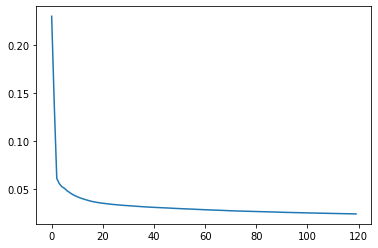

In [16]:
plt.plot(range(len(losslist)),losslist)

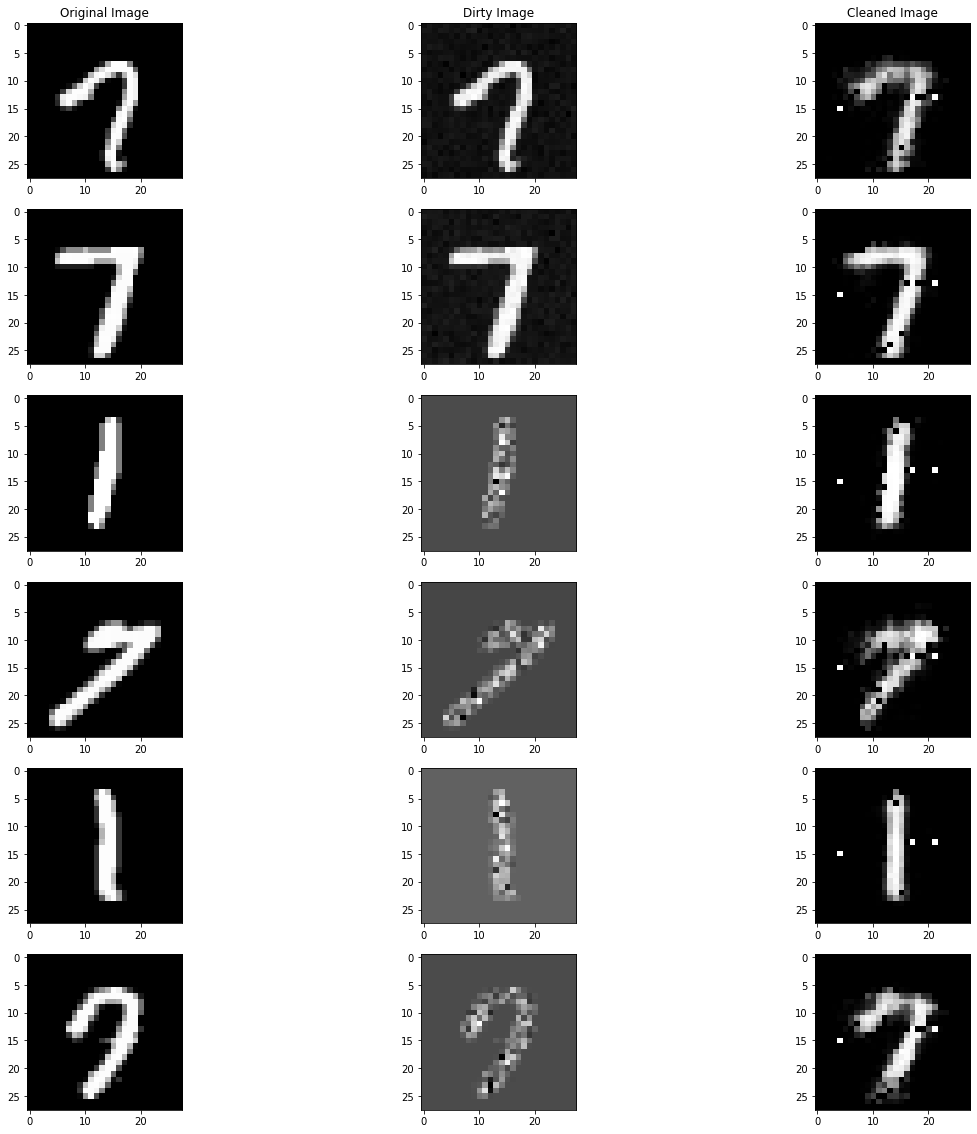

In [18]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
 """
f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,len(xtest),size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")

In [19]:
PATH = "model"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH   